# Startup

First we download needed libraries if not already installed, then we import them and set some useful global parameters.

In [1]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = False
if install_packages:
    %pip install pandas tqdm numpy matplotlib pyspark dask

In [2]:
####################
# LIBRARIES IMPORT #
####################

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import time
import re
from collections import deque

In [3]:
#####################
# GLOBAL PARAMETERS #
#####################

chunk_size = 100000 # 10000

authors_path = r"datasets/lighter_authors.json"
books_path = r"datasets/lighter_books.json"
list_path = r"datasets/list.json"
series_path = r"datasets/series.json"

# Loading the data into Pandas' Dataframe

The dataset provided is composed of 4 .json files:
* authors.json
* books.json
* list.json
* series.json

While the two latter are manageable the first two are very big and difficult to use. Instead of the whole files, for those two are provided lighter versions: "lighter_authors.json" is about 0.5 Gbs and "lighter_books.json" is 15 Gbs. Considering that where will be a data-type conversions the dataset will become even bigger when loaded on pandas and could not work on machines with limited amounts of RAM. We can approach this problem from two sides:
* Divide the dataset in chunks, work one chunk at a time and merge the results.
* For every request we could extract only the columns we are interested with.

Both those approaches are slow, we have to load every part of the dataset from the storage and load it on RAM for every exercise, and this increase considerably the amount of time to execute each query. Instead we try to load everything all at once, making the dataset as light as possible by removing columns useless for our analysis and where possible changing the data-type of useful columns to lighter versions.

## Authors dataset

In [4]:
# load the dataset from the .json file to a pandas dataframe
authors = pd.read_json(authors_path, lines = True)

In [5]:
# check the first lines of the dataframe
authors.head()

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,"Douglas Noël Adams was an English author, comi...",19826
1,1417316,4.02,84176,"[613469, 2305997, 940892, 2611786, 7800569, 31...","[9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...",75,7,Bill Bryson,male,https://images.gr-assets.com/authors/157859752...,"William McGuire ""Bill"" Bryson, OBE, FRS was bo...",16144
2,56159,4.53,352,"[17150, 808427, 20487307, 90550, 25460625, 171...","[349254, 15222, 14833682, 15221, 18126815, 152...",14,10,Jude Fisher,female,https://images.gr-assets.com/authors/141145711...,"Jude Fisher is the pseudonym for <a href=""http...",60
3,3302,3.79,480,"[4417, 14300808, 14780, 3796968, 44703121, 103...","[40, 9416484, 12482, 3753106, 26889789, 104764...",45,12,James Hamilton-Paterson,male,https://images.gr-assets.com/authors/127051738...,James Hamilton-Paterson's work has been transl...,72
4,7979,3.60,772,"[13330815, 19109351, 42306244, 72694240, 26291...","[8466327, 15739968, 22756778, 51026133, 260451...",61,14,Mark Watson,male,https://images.gr-assets.com/authors/133175379...,Mark Andrew Watson (born 13 February 1980) is ...,179


In [6]:
# check infos about each column
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351767 entries, 0 to 351766
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings_count       351767 non-null  int64  
 1   average_rating      351767 non-null  float64
 2   text_reviews_count  351767 non-null  int64  
 3   work_ids            351767 non-null  object 
 4   book_ids            351767 non-null  object 
 5   works_count         351767 non-null  int64  
 6   id                  351767 non-null  int64  
 7   name                351767 non-null  object 
 8   gender              351767 non-null  object 
 9   image_url           351767 non-null  object 
 10  about               351767 non-null  object 
 11  fans_count          351767 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.2+ MB


In [7]:
# check infos about the RAM usage of every column
raw_authors_memory_usage = authors.memory_usage(index = True, deep = True)
raw_authors_memory_usage

Index                       132
ratings_count           2814136
average_rating          2814136
text_reviews_count      2814136
work_ids               80361120
book_ids               80361120
works_count             2814136
id                      2814136
name                   26225127
gender                 21473021
image_url              44826054
about                 410897820
fans_count              2814136
dtype: int64

In [8]:
print("The dataset just as imported uses", round(raw_authors_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'about' column covers", round(raw_authors_memory_usage["about"] / raw_authors_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.63 GBs of RAM!
The 'about' column covers 60.0 % of the total RAM usage alone!


The columns "image_url" and "about" are useless for our analysis so they can be removed.

In [9]:
# remove the useless columns
authors.drop(columns = ["image_url", "about", "work_ids", "works_count"], inplace = True)
print("The dataset now uses", round(authors.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.13 GBs of RAM!


## Books

The books dataset is much bigger than the authors one and we can't work with it in one go, we have to separate it in chunks. Firstly we analyze what can be done with it by only observing some rows

In [10]:
# load a chunk of the dataset from the .json file to a pandas dataframe
books = pd.read_json(books_path, lines = True, nrows = 10000)

In [11]:
# check the first lines of the chunk
books.head()

,id,title,authors,author_name,author_id,work_id,isbn,isbn13,asin,language,...,format,edition_information,image_url,publisher,num_pages,series_id,series_name,series_position,shelves,description
0,2,Harry Potter and the Order of the Phoenix (Har...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2809203,0439358078,9780439358071,,eng,...,Paperback,US Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,870,45175,Harry Potter,5,"[{'name': 'to-read', 'count': 324191}, {'name'...",There is a door at the end of a silent corrido...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,4640799,,,,eng,...,Hardcover,Library Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc,309,45175,Harry Potter,1,"[{'name': 'fantasy', 'count': 63540}, {'name':...",Harry Potter's life is miserable. His parents ...
2,4,Harry Potter and the Chamber of Secrets (Harry...,None,J.K. Rowling,1077326,6231171,0439554896,9780439554893,,eng,...,Hardcover,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,352,45175,Harry Potter,2,"[{'name': 'to-read', 'count': 282341}, {'name'...",The Dursleys were so mean and hideous that sum...
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,2402163,043965548X,9780439655484,,eng,...,Mass Market Paperback,,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic Inc.,435,45175,Harry Potter,3,"[{'name': 'to-read', 'count': 292815}, {'name'...","For twelve long years, the dread fortress of A..."
4,6,Harry Potter and the Goblet of Fire (Harry Pot...,"[{'id': '1077326', 'name': 'J.K. Rowling', 'ro...",J.K. Rowling,1077326,3046572,,,,eng,...,Paperback,First Scholastic Trade Paperback Edition,https://i.gr-assets.com/images/S/compressed.ph...,Scholastic,734,45175,Harry Potter,4,"[{'name': 'to-read', 'count': 287086}, {'name'...",Harry Potter is midway through his training as...


In [12]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         9999 non-null   int64  
 1   title                      9999 non-null   object 
 2   authors                    3742 non-null   object 
 3   author_name                9999 non-null   object 
 4   author_id                  9999 non-null   int64  
 5   work_id                    9999 non-null   int64  
 6   isbn                       9999 non-null   object 
 7   isbn13                     9999 non-null   object 
 8   asin                       9999 non-null   object 
 9   language                   9999 non-null   object 
 10  average_rating             9999 non-null   float64
 11  rating_dist                9999 non-null   object 
 12  ratings_count              9999 non-null   int64  
 13  text_reviews_count         9999 non-null   int64

In [13]:
# check some infos about the RAM usage of every column
raw_books_memory_usage = books.memory_usage(index = True, deep = True)
raw_books_memory_usage

Index                             132
id                              79992
title                          929445
authors                        515672
author_name                    713677
author_id                       79992
work_id                         79992
isbn                           667641
isbn13                         697223
asin                           589989
language                       596758
average_rating                  79992
rating_dist                    972520
ratings_count                   79992
text_reviews_count              79992
publication_date               654329
original_publication_date      638162
format                         655109
edition_information            610372
image_url                     1484359
publisher                      710464
num_pages                      401847
series_id                      598856
series_name                    634022
series_position                588928
shelves                       6070816
description 

In [14]:
print("The dataset just as imported uses", round(raw_books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")
print("The 'description' column covers", round(raw_books_memory_usage["description"] / raw_books_memory_usage.sum(), 2) * 100, "% of the total RAM usage alone!")

The dataset just as imported uses 0.03 GBs of RAM!
The 'description' column covers 35.0 % of the total RAM usage alone!


The scenario is similar to the authors dataset, there is a column of long text descriptions that occupy a large amount of memory and it's useless to us. We remove it together with other useless columns, where we consider a column useless when no exercise require it.

In [15]:
# remove the useless columns
books.drop(columns = ["isbn", "isbn13", "asin", "edition_information", "publisher", "image_url", "description", "shelves", "publication_date"], inplace = True)
print("The dataset now uses", round(books.memory_usage(index = True, deep = True).sum() / 1073741824, 2), "GBs of RAM!")

The dataset now uses 0.01 GBs of RAM!


Now we try to load the whole books dataset, chunk by chunk, and removing the useless parts.

In [16]:
books = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)
columns_to_drop = ["work_id", "isbn", "isbn13", "asin", "edition_information", "image_url", "publisher", "shelves", "description", "publication_date"]

for chunk in tqdm(chunks, total = chunks_number):
    chunk.drop(columns = columns_to_drop, inplace = True)
    books = pd.concat([books, chunk])

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [17]:
# check some infos about each column
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027431 entries, 0 to 7027430
Data columns (total 16 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   title                      object 
 2   authors                    object 
 3   author_name                object 
 4   author_id                  int64  
 5   language                   object 
 6   average_rating             float64
 7   rating_dist                object 
 8   ratings_count              int64  
 9   text_reviews_count         int64  
 10  original_publication_date  object 
 11  format                     object 
 12  num_pages                  object 
 13  series_id                  object 
 14  series_name                object 
 15  series_position            object 
dtypes: float64(1), int64(4), object(11)
memory usage: 857.8+ MB


In [18]:
# check some infos about the RAM usage of every column
books_memory_usage = books.memory_usage(index = True, deep = True)
books_memory_usage

Index                              132
id                            56219448
title                        684810705
authors                      293131784
author_name                  510420434
author_id                     56219448
language                     417560422
average_rating                56219448
rating_dist                  630673989
ratings_count                 56219448
text_reviews_count            56219448
original_publication_date    454730116
format                       447158221
num_pages                    323639741
series_id                    420869401
series_name                  445383460
series_position              413558394
dtype: int64

In [19]:
print("The dataset uses", round(books_memory_usage.sum() / 1073741824, 2), "GBs of RAM!")

The dataset uses 4.96 GBs of RAM!


# Research questions [RQs]

## [RQ1] Exploratory Data Analysis (EDA)

In the Authors dataset what's the difference between "book" and "work"?

The Books dataset has some void string entries in the num_pages column.

Negative average ratings and ratings count and fans count.

### Analyze authors

In [20]:
authors.describe()

,ratings_count,average_rating,text_reviews_count,id,fans_count
count,3.517670e+05,351767.000000,351767.000000,3.517670e+05,351767.000000
mean,4.770586e+03,3.651194,330.993243,7.751861e+06,111.615731
std,9.769395e+04,1.211482,3857.539191,6.578409e+06,2661.018139
min,-4.100000e+01,-31.000000,0.000000,4.000000e+00,-33.000000
25%,6.000000e+00,3.600000,1.000000,1.535315e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.470396e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,1.434041e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,2.124802e+07,766035.000000


In [21]:
l=[]
for i in range(len(authors['average_rating'])):
    if authors['average_rating'][i]<0:
        print(i)
        l.append(i)
    if authors['ratings_count'][i]<0:
        print(i) 
        l.append(i)
    if authors['fans_count'][i]<0:
        print(i)
        l.append(i)
l  

104296
129604
253327
253327
264572
264606
264611
264638
264743
264747
264859
264876
264878
264919
265036
265152
270664
274931
274940
275034
275039
275082
282878
285757
286226
337953
338249
343284


[104296,
 129604,
 253327,
 253327,
 264572,
 264606,
 264611,
 264638,
 264743,
 264747,
 264859,
 264876,
 264878,
 264919,
 265036,
 265152,
 270664,
 274931,
 274940,
 275034,
 275039,
 275082,
 282878,
 285757,
 286226,
 337953,
 338249,
 343284]

In [22]:
l = list(set(l))
l

[275082,
 253327,
 286226,
 264859,
 264606,
 337953,
 264611,
 264743,
 264747,
 264876,
 264878,
 264572,
 285757,
 264638,
 265152,
 129604,
 270664,
 338249,
 265036,
 264919,
 275034,
 275039,
 104296,
 274931,
 343284,
 274940,
 282878]

In [23]:
for i in l:
    authors= authors.drop(i)
    
authors.describe()

,ratings_count,average_rating,text_reviews_count,id,fans_count
count,3.517400e+05,351740.000000,351740.000000,3.517400e+05,351740.000000
mean,4.770952e+03,3.651283,331.018414,7.751783e+06,111.624663
std,9.769769e+04,1.210085,3857.686173,6.578581e+06,2661.120073
min,0.000000e+00,0.000000,0.000000,4.000000e+00,0.000000
25%,6.000000e+00,3.600000,1.000000,1.534690e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.470274e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,1.434083e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,2.124802e+07,766035.000000


now there no 'strange' values and ratings_count, average_rating and fans_count have not any outlier

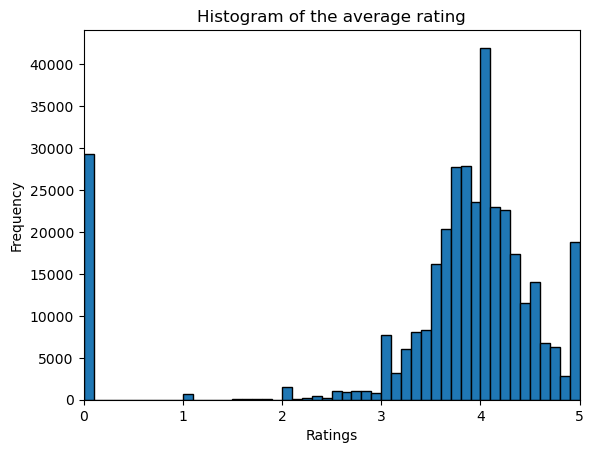

<Figure size 500x500 with 0 Axes>

In [24]:
#hist of the average ratings of all the authors
import matplotlib.pyplot as plt 
plt.hist(authors.average_rating, bins=50, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()

As we can see there are a lot of ratings with values from 4.0 to 5.0 and 0 and only a small part with rating values from 1.0 to 3.0

In [25]:
#plot of the works_count of all the authors
import matplotlib.pyplot as plt 
plt.bar(authors.name, authors.works_count, color='skyblue')

#plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating')
plt.figure(figsize=(5, 5))
plt.show()

AttributeError: 'DataFrame' object has no attribute 'works_count'

In [ ]:
from sklearn.preprocessing import StandardScaler

X = authors[["average_rating"]]
Y = authors[["ratings_count"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
Y_standardized = scaler.fit_transform(Y)

df_standardized = pd.DataFrame({"X_standardized": X_standardized.flatten(), "Y_standardized": Y_standardized.flatten()})

plt.scatter(df_standardized["X_standardized"], df_standardized["Y_standardized"], color='blue', marker='o')

plt.title('Plot: average_rating and ratings_count')
plt.xlabel('average_rating')
plt.ylabel('ratings_count')
plt.grid(True)


plt.show()

In [ ]:
plt.scatter(authors['average_rating'] ,authors['ratings_count'], color='blue', marker='o',alpha=0.5)#scatterplot of average ratings and rating count
plt.show()
print(authors['average_rating'].corr(authors['ratings_count']))  #correlation between average ratings and rating count

The correlation between average ratings and rating count is very close to 0, that indicates that there is no relationship between the two variables.

In [ ]:
plt.scatter(authors.average_rating, authors.fans_count, color='red', marker='o', alpha=0.5)

plt.show()

print(authors['average_rating'].corr(authors['fans_count']))

The correlation between average ratings and fans count is very close to 0, that indicates that there is no relationship between the two variables.

In [ ]:
X = authors[["works_count"]]
Y = authors[["fans_count"]]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
Y_standardized = scaler.fit_transform(Y)

df_standardized = pd.DataFrame({"X_standardized": X_standardized.flatten(), "Y_standardized": Y_standardized.flatten()})

plt.scatter(df_standardized["X_standardized"], df_standardized["Y_standardized"], color='red', marker='o')

plt.title('Plot: works_count and fans_count')
plt.xlabel('works_count')
plt.ylabel('fans_count')
plt.grid(True)


plt.show()

correlation = df_standardized['X_standardized'].corr(df_standardized['Y_standardized'])
print(correlation)

The correlation between works count and fans count is very close to 0, that indicates that there is no relationship between the two variables.

### Analize books

In [ ]:
books.describe()

In [ ]:
books.language.value_counts().head(50)

## [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:

**Request 2.1:** Plot the number of books for each author in descending order.

In [ ]:
counts = books['author_name'].value_counts().sort_values(ascending=False).head(70)

plt.figure(figsize=(15, 10))
plt.bar(counts.index, counts.values, color='skyblue')
plt.title('Number of Books per Author (Descending Order)')
plt.xlabel('Author Name')
plt.ylabel('Number of Books')
plt.xticks(rotation=90)
plt.show()

**Request 2.2:**  Which book has the highest number of reviews?

---

We simply do a query using the books dataset.

In [ ]:
books[books["text_reviews_count"] >= max(books["text_reviews_count"])]

**Request 2.3:** Which are the top ten and ten worst books concerning the average score?

In [ ]:
books.nlargest(10, "average_rating")

In [ ]:
books.nsmallest(10, "average_rating")

**Request 2.4:** Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

In [ ]:
books.language.head(30)
#there are some spazi vuoti

In [ ]:
for i in range(len(books.language)):
    if books.language[i]=='':
        print(i)    

There are many nan value so we decide to use a dataset without them

In [ ]:
lingua = books[books["language"] != ""]
lingua

In [ ]:
languages = lingua['language'].value_counts().head(20)
plt.bar(languages.index, languages.values, color='skyblue')
plt.xticks(rotation=90)

As we can see from the graphic, a large part of the dataset is made up of books written in English (non specified if is US or CA or GB english) which is the 72.5% of all. Adding the US/GB/CA English the English books are the 83.5% of all the books.

In [ ]:
lingua['language'].value_counts()

In [ ]:
n=len(lingua['language'])

perc_ing=32420/n*100
perc_ing

**Request 2.5:** How many books have more than 250 pages?

Notice that there are some entries that have a void string instead of the number of pages.

In [ ]:
# create a view that excludes the entries with void string
df = books[books["num_pages"] != ""]

# execute query
result = df[df["num_pages"].astype(int) > 250].shape[0]

print(result)

**Request 2.6:** Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

In [ ]:
top_authors = authors.sort_values(by="works_count", ascending=False).head(50)
plt.bar(top_authors["name"], top_authors["fans_count"], color='blue')
plt.xticks(rotation=90)
plt.figure(figsize=(15, 10))

There are some 'strange' values like NOT A BOOK or Unknown or Anonymous, let's plot without these values

In [ ]:
df = authors[(authors["name"] != "NOT A BOOK") & (authors["name"] != "Unknown") & (authors["name"] != "Anonymous")]

In [ ]:
top_authors = df.sort_values(by="works_count", ascending=False).head(50)
plt.bar(top_authors["name"], top_authors["fans_count"], color='blue')
plt.xticks(rotation=90)
plt.figure(figsize=(15, 10))

In [ ]:
top_authors

## [RQ3] Let’s have a historical look at the dataset!

**Request 3.1:** Write a function that takes as input a year and returns as output the following information:

* The number of books published that year.
* The total number of pages written that year.
* The most prolific month of that year.
* The longest book written that year.

In [ ]:
# num pages cleaning
df = books[books["num_pages"] != ""]
df["num_pages"] = df["num_pages"].astype(int)

# date information gathering
# TODO CHANGE ORIGINAL PUBLICATION DATE WITH PUBLICATION DATE
pattern = r"(-?[1-9][0-9]{3}|[1-9][0-9]{2}|[1-9][0-9]|[0-9])(?:-(0[1-9]|1[0-2]))?(?:-([0-2][0-9]|3[0-1]))?"
df[["year", "month", "day"]] = df["original_publication_date"].str.extract(pattern)
df = df[~df["year"].isna()]

We decided to ignore every book that has an invalid date format. We decided to also treat those years that have negative date (meaning BC), however for those dates (but not only for those) no month is given. Also some years for which month are used they are not always present. When they are present we for the calculation about the most prolific month we only use those books who specify the month, while when no month is specified we use the placeholder value "00".

In [ ]:
def look_by_year(books, year):
    books_year = books[books["year"] == str(year)]

    n_books = books_year.shape[0]
    tot_pages = books_year["num_pages"].sum()
    longest_book = books_year[books_year["num_pages"] >= books_year["num_pages"].max()]["title"].head(1).item()

    try:
        prolific_month = books_year.groupby("month")["num_pages"].sum().idxmax()
    except ValueError as e:
        prolific_month = "00"

    return n_books, tot_pages, prolific_month, longest_book

# test the function with a random year

look_by_year(df, 2000)

**Request 3.2:** Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

In [ ]:
per_year_dataset = pd.DataFrame()

for year in tqdm(df["year"].unique(), total = df["year"].unique().shape[0]):
    per_year_dataset = pd.concat([per_year_dataset, pd.DataFrame((year,) + look_by_year(df, year)).T])

per_year_dataset = per_year_dataset.rename(columns = {0: "year", 1: "num_books", 2: "tot_pages", 3: "prolific_month", 4: "longest_book"})
per_year_dataset = per_year_dataset.set_index("year")

In [ ]:
per_year_dataset.head(10)

In [ ]:
per_year_dataset.tail(10)

**Request 3.3:** Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

## [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

**Request 4.1:** You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [ ]:
#Check whether the entry is a duplicate or a different author

names = authors['name'].value_counts()
dupl_auth = names[names > 1]

print("Number of double entries: ", len(dupl_auth))

eponymous = []
duplicates = []

# iterate through the authors dataframe names, and if the same name matches 2 ids, append to eponymous, otherwise if singular id for both entries, append to duplicates

for i in range(len(dupl_auth.index)):
    auth_df = authors[authors['name'] == dupl_auth.index[i]]
    if len(list(set(auth_df['book_ids'].iloc[0] + auth_df['book_ids'].iloc[1]))) == len(auth_df['book_ids'].iloc[0]) + len(auth_df['book_ids'].iloc[1]):
        eponymous.append(dupl_auth.index[i])
    else:
        duplicates.append(dupl_auth.index[i])
    
print("The duplicate entries referring to the same authors are:\n", duplicates)
print("\n The actually eponymous authors are:\n", eponymous)


**Request 4.2:** Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

In [ ]:
def author_works_dic(author_ids: list):
    auth_books = {i: None for i in author_ids}
    for i in author_ids:
        try:
            bks = authors[authors['id'] == i].iloc[0][4] 
            ttls = list()
            for bk in bks:                   
                if books[books['id'] == int(bk)].shape[0] != 0: 
                    ttls.append(books[books['id'] == int(bk)].iloc[0]['title']) 
            auth_books[i] = ttls 
        except IndexError:
            print("No author with ID: ", i)
    return auth_books

**Request 4.3:** What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

In [ ]:
top_20_rating_auth = authors.nlargest(10, "average_rating")["id"]
top_20_rating_books = author_works_dic(top_20_rating_auth)

longest_title = ""

for i in top_20_rating_books.values():
    for title in i:
        if len(title) > len(longest_title):
            longest_title = title

longest_overall_title = books['title'].str.len().idxmax()
print("The longest title is:", longest_title)
print("\n The longest overall title is:", longest_overall_title)


**Request 4.4:** What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

In [ ]:
if not books["title"].isnull():
    shortest_book_ever = books["title"].str.len().idmin()

print(shortest_book_ever)

## [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.

**Request 5.1a:** Plot the top 10 most influential authors regarding their fan count and number of books.

In [ ]:
# count the actual number of books written by every author using the length of the list of his book ids.
authors["book_count"] = authors["book_ids"].apply(len)

# 10 most influential authors regarding their fan count
x = authors.nlargest(10, "fans_count")

# plot the data
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["fans_count"], color = 'green', label = 'Fan Count')
plt.figure(figsize=(12, 6))
plt.barh(x["name"], x["book_count"], color = 'blue', label = 'Book Count')
plt.show()

**Request 5.1b:** Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

In [ ]:
# most influential author
m_inf = authors.nlargest(1, "fans_count")
print("The most influential author, having by far the largest fanbase is:", m_inf["name"].to_string(index = False))

**Request 5.2:** Have they published any series of books? If any, extract the longest series name among these authors.

In [ ]:
# create a new dataframe containing only the books written by the top 10 authors
top_authors_books = books[books["author_id"].isin(list(x["id"]))]

# get the series authors by their "series position" to find who has written series, and use max position to determine their longest series' length.
author_series_lengths = top_authors_books.groupby(["author_id", "author_name"])["series_position"].max().reset_index()

# return the highest series position, thus the longest series author and name
author_series = top_authors_books.groupby(["author_id", "author_name", "series_name"])["series_position"].max().reset_index()
max_series = author_series[author_series["series_position"] == author_series["series_position"].max()]

print("Authors of series are:")
print(author_series_lengths["author_name"].to_string(index = False))

print("\nThe author of the longest series is:")
print(max_series["author_name"].to_string(index = False))
print("And the series is:")
print(max_series["series_name"].to_string(index = False))

**Request 5.3:** How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

In [ ]:
# to find the authors published in different formats from the top 10
authors_with_different_formats = top_authors_books[top_authors_books.duplicated(subset=["author_id"], keep = False)]
authors_with_different_formats = authors_with_different_formats[authors_with_different_formats["format"] != ""]

# to avoid name repetition
unique_author_ids = authors_with_different_formats["author_id"].unique()

# create a separate chart for each author with multiple formats
for author_id in unique_author_ids:
    author_data = authors_with_different_formats[authors_with_different_formats["author_id"] == author_id]
    author_name = author_data["author_name"].values[0]
    format_distribution = author_data["format"].value_counts()
    
    format_distribution.plot(kind='bar')
    plt.title(f"Formats Distribution for {author_name}")
    plt.xlabel("Format")
    plt.ylabel("Count")
    plt.show()

**Comments on the graphs above:** we can see that the books are mainly published in paperback and hardcover formats, whereas the "newer" digital formats are very few. This would be due to 3 main reasons: 
1- the age of most of the books written by these authors since audiobooks and ebook formats are relatively new.
2- even with more widely available digital formats now, these are authors of novels and readers who usually enjoy leisurely reading prefer the physical format of paper, rather than reading through a screen.
3- Once a book has been published in a digital format, there is no need to republish it using another editorial, since it is already on the internet, a more universal "bookstore".

**Request 5.4:** Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” You may want to have a look at the following recommended readings:

- https://bhm.scholasticahq.com/article/38021
- https://priyanka-ddit.medium.com/how-to-deal-with-imbalanced-dataset-86de86c49
- https://compass.onlinelibrary.wiley.com/doi/10.1111/soc4.12962

You can even ask ChatGPT or any other LLM chatbot tool: try to formulate a prompt that provides helpful information about it. Put that information in your notebook and provide comments on what you found.

In [ ]:
# Transform gender values to "male," "female," or "other"
authors['gender'] = authors['gender'].str.lower().apply(
    lambda x: 'male' if x == 'male' else ('female' if x == 'female' else 'other'))

# Group the new simpler data by gender, and get mean values
gender_grouped = authors.groupby('gender').agg({'average_rating': 'mean', 'fans_count': 'mean'}).reset_index()

# Plots to visibly show any disparities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first subplot for average ratings
ax1.bar(gender_grouped['gender'], gender_grouped['average_rating'])
ax1.set_title('Average Ratings by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Mean Average Rating')

# Plot the second subplot for fan counts
ax2.bar(gender_grouped['gender'], gender_grouped['fans_count'])
ax2.set_title('Fan Counts by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Mean Fan Count')

plt.show()

**Analysis:**

Average Ratings:

In terms of average rating, males, females and unassigned authors do not witness any visible disparity, all being relatively close to each other with only a slight advantage for females.

Fan Count:

The fan count is another story however where females have a far higher fan count than both males and "other", at almost double the men's and quadruple the "others". 

Please note now however that this analysis still holds regardless of the "heavy" cleaning and grouping of genders since even if some of the "grouped values" like he/him for example would actually be grouped into the "male" section. The reason why the distribution would still be similar under the assumption that the "falsely grouped" values would be evenly spread into both "male and female", where the only final result that would meaningfully change is the number of fans to the authors who really fall into the "others" group.

## [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

    Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?
    For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

**Request 6.1:** Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [ ]:
# step 1: transform the publication date entry to datetime format
top_authors_books["original_publication_date"] = pd.to_datetime(top_authors_books["original_publication_date"], format = 'mixed')

# calculate time gap between consecutive "original" publications and add it into a column for all books
top_authors_books["time_gap"] = top_authors_books.groupby(["author_id", "series_id"])["original_publication_date"].diff()

# calculate the average time gap for books in a series and not in a series, according to the new column created
average_time_gap_series = top_authors_books[top_authors_books["series_id"].notna()]["time_gap"].mean()
average_time_gap_non_series = top_authors_books[top_authors_books["series_id"].isna()]["time_gap"].mean()

# print(f"Average Time Gap for Books in a Series: {average_time_gap_series}")
# print(f"Average Time Gap for Books Not in a Series: {average_time_gap_non_series}")
print(top_authors_books)

**What do we expect to see?** As expected the books that belong to a series have a more periodic and regular output from the authors(on average), and this logically makes sense following the idea that the author is breaking down a full story into separate books.
Books that do not belong to a series however do not have a well-defined average gap between them since they are independent works and do not follow any periodic output "expectation" from the public.

**Request 6.2:** For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

In [ ]:
# define a new column using the datetime format of the original publication date
top_authors_books['year'] = top_authors_books["original_publication_date"].dt.year
writers_counts = top_authors_books.groupby(['author_name', 'year']).size().reset_index(name='Count')

# plot the publication history for each author
writers = writers_counts['author_name'].unique()
for writer in writers:
    author_data = writers_counts[writers_counts['author_name'] == writer]
    plt.plot(author_data['year'], author_data['Count'], label=writer)

plt.title("Publication History of Authors")
plt.xlabel("Year")
plt.ylabel("Number of Books Published")
plt.legend()
plt.show()

## [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!

**Request 7.1:** Estimate the probability that a book has over 30% of the ratings above 4.

---

We can do this by counting how many books have 30% of the rating above 4 (i.e. a rating of 5 since you can only give an integer beteween 1 and 5 as rating) and dividing it by the total number of books.

In [ ]:
books[books["rating_dist"] == "5:-1|4:1|3:1|2:0|1:0|total:1"]
books[books["rating_dist"] == "5:0|4:0|3:3|2:-1|1:-1|total:1"]

In [ ]:
# on slack they said you should get also 4 scores

def has_30p_above_four(rating_dist):
    pattern = r"5:([0-9]+)\|4:[0-9]+\|3:[0-9]+\|2:[0-9]+\|1:[0-9]+\|total:([0-9]+)"

    match = re.search(pattern, rating_dist)
    if int(match.group(1)) > 0.3 * int(match.group(2)):
        return True
    else:
        return False

df = books.drop(index = [6650514, 7011288]) # we remove this specific cases because the rating distribution is wrong
above_four = sum(df["rating_dist"].apply(has_30p_above_four))

result = above_four / df.shape[0]
print(result)

**Request 7.2:** Estimate the probability that an author publishes a new book within two years from its last work.

---

Not every author on the authors dataset has a book in the books dataset, that is because our datasets are only a subset of the original one. This means that we there could be come authors that have published a new book within two years from their last work but since that book istance is not present in our dataset and we do not count it. However we could not even say that our estimate is a lower bound of the real probability because not every author is present in our dataset.

We divide by the number of books minus the number of authors to obtain the total number of "non-first books".

TODO Dobbiamo contare quanti autori lo hanno fatto almeno una volta o quanti libri hanno questa proprietà?

In [58]:
df = books
pattern = r"(-?[1-9][0-9]{3}|[1-9][0-9]{2}|[1-9][0-9]|[0-9])(?:-(0[1-9]|1[0-2]))?(?:-([0-2][0-9]|3[0-1]))?"
df[["year", "month", "day"]] = df["original_publication_date"].str.extract(pattern)
df = df[(~df["year"].isna())]
df["month"] = df["month"].fillna(0).astype(int) + df["year"].astype(int) * 12
df.drop(["year", "day"], axis = 1, inplace = True)

grouped = df.groupby("author_id")

score = 0
for group_name, group_data in tqdm(grouped, total = grouped.ngroups):
    group_data = group_data.sort_values(by = "month")
    previous = group_data["month"].head(1).item()

    for elem in group_data["month"]:
        if elem - previous != 0 and elem - previous <= 48:
            score += 1

result = score / (df.shape[0] - df["author_id"].unique().shape[0])
print("The probability that an author publishes a new book whitin two years from it's last work is: ", result)

C:\Users\Utente\AppData\Local\Temp\ipykernel_7468\1005961742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"] = df["month"].fillna(0).astype(int) + df["year"].astype(int) * 12
C:\Users\Utente\AppData\Local\Temp\ipykernel_7468\1005961742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["year", "day"], axis = 1, inplace = True)


  0%|          | 0/254010 [00:00<?, ?it/s]

The probability that an author publishes a new book whitin two years from it's last work is:  0.17181312350820072


**Request 7.3:** In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

---

We call the "Book is in the worst books list" event $A$ and "Book has more than 700 pages" event $B$. We use Bayes' formula:

$\mathbb{P}(\text{A | B}) = \frac{\mathbb{P}(\text{B | A}) \;\cdot\; \mathbb{P}(\text{A}) }{\mathbb{P}(\text{B})}$

* $\mathbb{P}(\text{A})$: the probability that a book is in the worst books list. Obtained by counting the entries in "The Worst Books of All Time" list and dividing it by the number of books in the dataset.
* $\mathbb{P}(\text{B})$: the probability that a book has more than 700 pages. Obtained by counting the entries with more than 700 pages and dividing it by the number of books in the dataset.
* $\mathbb{P}(\text{B | A})$: the probability of a book having more than 700 pages knowing that it is in the worst book list. Obtained by doing the second query over the books identified by first one.

In [ ]:
df = books[books["num_pages"] != ""]

worst_books = pd.read_json(list_path, lines = True, nrows = 1)["books"][0]
worst_books = pd.DataFrame(worst_books)
worst_books["book_id"] = worst_books["book_id"].astype(int)
n_worst_books = worst_books.shape[0]
join = pd.merge(worst_books, df, left_on = "book_id", right_on = "id", how = "inner", suffixes = ["_w", "_b"])

pA = n_worst_books / df.shape[0]
pB = df[df["num_pages"].astype(int) > 700].shape[0] / (df.shape[0])
pBA = join[join["num_pages"].astype(int) > 700].shape[0] / (join.shape[0])
pAB = pBA * pA / pB

print("P(A | B), the probability of a book being included in the worst books list, knowing it has more than 700 pages: ", pAB)

**Request 7.4:** Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

---

To check whether the X and Y are indipendent we can apply the definition of indipendence. Two events are indipendent if knowing that one happened does not change the probability of the second one appearing. Formally speaking, that is when:

$\mathbb{P}(X \cap Y) = \mathbb{P}(X) \cdot \mathbb{P}(Y)$

To reuse the previously calculated probabilities we can also add the definition of conditional probability:

$\mathbb{P}(X | Y) = \frac{\mathbb{P}(X \cap Y)}{\mathbb{P}(Y)}$

From which we obtain that if X and Y are indipendent:

$\mathbb{P}(X | Y) = \mathbb{P}(X)$

$\mathbb{P}(Y | X) = \mathbb{P}(Y)$


We called X as A and Y as B. Then to check for indipendence we can just check whether $\mathbb{P}(\text{A | B})$ and $\mathbb{P}(\text{B | A})$ are equal respectively to $\mathbb{P}(A)$ and $\mathbb{P}(B)$. To be precise indipendence is a two-way relation, so if one holds also the second must hold, this means we really only need to check one of those two.

In [ ]:
# df["in_worst_book_list"] = df["id"].apply(lambda x: x in worst_books["book_id"].values)
# df["more_700_pages"] = df["num_pages"].apply(lambda x: x > 700)

print("Test 1:")
print("P(A), the probability of a book of the whole dataset to be in the worst books list: ", pA)
print("P(A | B), the probability of a book to be in the worst books list, knowing that it has more than 700 pages: ", pAB)

print("Test 2:")
print("P(B), the probability of book of the whole dataset to have more than 700 pages over the total: ", pB)
print("P(B | A), the probability of books to have more than 700 pages knowing that it is in the worst books list: ", pBA)

As we can see the two events are dependent.

## [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

**Request 8.1:** Can you demonstrate that readers usually rate the longest books as the worst?

In [ ]:
df = books[books["num_pages"] != ""]
df["num_pages"] = df.num_pages.astype(int)

# we try to remove outliers
df = df[(df["num_pages"] < 1500) & (df["num_pages"] != 0) & (df["average_rating"] != 0)]

In [ ]:
plt.scatter(df["num_pages"], df["average_rating"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Num pages")
plt.ylabel("Average rating")

z = np.polyfit(df["num_pages"],  df["average_rating"], 1)
p = np.poly1d(z)
plt.plot(df["num_pages"], p(df["num_pages"]), color= "black")

plt.show()

This scatterplot is confusing, we try to use a heatmap.

In [ ]:
plt.hexbin(df["num_pages"], df["average_rating"], gridsize = 20, bins = "log", edgecolor = "gray")

z = np.polyfit(df["num_pages"],  df["average_rating"], 1)
p = np.poly1d(z)
plt.plot(df["num_pages"], p(df["num_pages"]), color= "black")

plt.xlabel("Num pages")
plt.ylabel("Average rating")
plt.colorbar()

In [ ]:
correlation = df["average_rating"].corr(df["num_pages"])
print("The correlation coefficient between 'average_rating' and 'num_pages' is:", correlation)

We see the correlation coefficient is and in the positive direction, hinting at a faint positive correlation between the number of pages and the average rating. Without our data selection the correlation is even fainter but always in a positive direction. This means that we can't demonstrate that readers usually rate the longest books as the worst, instead even if the effect is very little it's the opposite.

---

**Request 8.2:** Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

In [ ]:
#split the books into 2 groups
eng_books = lingua[(lingua['language'] == 'eng') | (lingua['language'] == 'en-US') | (lingua['language'] == 'en-GB') | (lingua['language'] == 'en-CA')]
non_eng_books = lingua[(lingua['language'] != 'eng') & (lingua['language'] != 'en-US')& (lingua['language'] != 'en-GB') & (lingua['language'] != 'en-CA')]

First of all let's check the histograms of the average ratings of each groups

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(eng_books.average_rating, bins=50, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating for english books')
plt.figure(figsize=(5, 5))
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(non_eng_books.average_rating, bins=50, edgecolor='black')
plt.xlim(0,5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of the average rating for non english books')
plt.figure(figsize=(5, 5))
plt.show()

From the histograms it looks like there are no differences of ratings if the book is written in english or not. The two distributions are similar to a normal distribution.
Let's see if this hypothesis is true or not doing some test. I choose to do a t-test which is a parametric test for determining correlations between two samples of data.

So we define:
* The null hypothesis H0 is: there no difference between the 2 groups in terms of average rating.
* The alternative hypothesis H1 is: there is a difference between the 2 groups in terms of average rating.

We also need to choose an alpha, usually is 0.05, which means that the probability to say that they are different when they are not is not more than 5%.

In [ ]:
print(np.var(eng_books.average_rating))
print(np.var(non_eng_books.average_rating))

They have different variance

In [ ]:
from scipy.stats import ttest_ind

alpha = 0.05
t_statistic, p_value = ttest_ind(eng_books['average_rating'], non_eng_books['average_rating'], equal_var=False)

print("p-value:", p_value)
print("t-statistic:", t_statistic)

The resulting p-value is smaller than alpha, so we reject the null hypothesis, this means that there is a significant difference between the distribution of the average rating of the two groups.

**Request 8.3:** About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

In [ ]:
print(eng_books.average_rating.describe())
print("The mode is:", statistics.mode(eng_books.average_rating))

In [ ]:
print(non_eng_books.average_rating.describe())
print("The mode is:", statistics.mode(non_eng_books.average_rating))

In [ ]:
fig = plt.figure(figsize =(10, 7))
 
ax = fig.add_axes([0, 0, 0.7, 0.6])
libri=[eng_books.average_rating, non_eng_books.average_rating]
box = ax.boxplot(libri, widths=0.5) 

ax.set_xticklabels(['english books','non english books'])
plt.title('Boxplot of average rating') 

plt.show()

In a boxplot the median is represented by the yellow line, and the first and third quintile are represented by the upper and lower line of the box.\
So for example: \
For the english books the median is 3.96 this means that 50% of the values are lower than 3.96 and if we see the distance of the first and third quintile from the median, we can notice that they are quite similar so this means they are simmetrical.\
The mode helps to identify around which value the distribution is centered in this case for the two groups is 4 and as we can see from the boxplots the distributions are centered in this value.\
Mean is not visible in the boxplot and for each group median and mean are softly different.

**Request 8.4:** It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

In [ ]:
df = authors[authors["fans_count"] != 0]

The assumption is that fans of popular authors are more "lazy" and leave less reviews. We can check if there is a correlation between the numbers of fans and number of reviews.

In [ ]:
plt.scatter(df["fans_count"], df["ratings_count"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")

z = np.polyfit(df["fans_count"],  df["ratings_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.show()

There is a correlation between the two. However a more precise measure would be to check for every author it's factor of "review per fan", that better shows the fact that fans of great authors are more lazy or not.

In [ ]:
plt.scatter(df["fans_count"], df["ratings_count"] / df["fans_count"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")

z = np.polyfit(df["fans_count"],  df["ratings_count"] / df["fans_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.show()

Outliers render the scatterplot difficult to read. Let's see something about this strange values.

In [ ]:
outlier = df[(df["ratings_count"] / df["fans_count"]) == (df["ratings_count"] / df["fans_count"]).max()]
outlier

In the provided book dataset there is no information about what book this author wrote, but searching online we can see she is written as the editor of some of the most important Shakespeare plays, like Romeo and Juliet. This means that the column "rating_count" counts not only those books for which the person is the main author but everything that author has worked on. This also explains why she has a very high ratings count while having a very low fan count.

We can try to remove this kind of authors from our dataset by setting a minimum threshold for "fan_count".

In [ ]:
df = authors[authors["fans_count"] > 2500]

In [ ]:
plt.scatter(df["fans_count"], df["ratings_count"] / df["fans_count"])

plt.ticklabel_format(axis = "y", style = "plain")
plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")

z = np.polyfit(df["fans_count"],  df["ratings_count"] / df["fans_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.show()

And as before we also plot a heatmap to better understand the distribution:

In [ ]:
plt.hexbin(df["fans_count"], df["ratings_count"] / df["fans_count"], gridsize = 20, bins = "log", edgecolor = "gray")

z = np.polyfit(df["fans_count"],  df["ratings_count"] / df["fans_count"], 1)
p = np.poly1d(z)
plt.plot(df["fans_count"], p(df["fans_count"]), color= "black")

plt.xlabel("Fans count")
plt.ylabel("Ratings per fan")
plt.colorbar()

In the end we can say that the assumption made was correct, but the correlation is not very strong. TODO

**Request 8.5:** Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

TODO

# Bonus points

## 1

**Request 1.1:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.

In [ ]:
# TRY ON MAIN PC

# IN PANDAS

print("Measuring Pandas performance...")
%timeit authors[authors["text_reviews_count"] >= 100]

# IN DASK

authors_dask = dd.from_pandas(authors, npartitions = 1)

print("Measuring Dask performance...")
%timeit authors_dask[authors_dask["text_reviews_count"] >= 100].compute()

Dask is a library very similar to Pandas but specialized to work on bigger datasets. It's greatest characteristic is intended parallel computing, intended both as local, where different cores of the same CPU are used at the same time, and cloud, where the computation is divided between computers clusters. Another important difference is it's "lazy evalutaion", operations are not executed when requested in the code but instead they are delayed and really executed only when explicitly told so or when necessart (Ex. if we request to plot the data it's necessary for the computation to be done).


TODO
We can't observe a meaningful difference between the two operations because the dataset is small and the machine this is executed on...

---

**Request 1.2:** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

In [ ]:
# TODO

join = pd.merge(books, authors, left_on = "author_id", right_on = "id", how = "left")[["id_y"]]
authorless_istances = join["id_y"].isna().sum()
print("Authorless istances: ", authorless_istances)

In [ ]:
join = dd.merge(dd.from_pandas(books, npartitions = 1), dd.from_pandas(authors, npartitions = 1), left_on = "author_id", right_on = "id", how = "left")
authorless_instances = join["id_y"].isna().sum().compute()
print("Authorless instances: ", authorless_instances)

## 2 Every book should have a field named description, and any author should have a field named description. Choose one of the two and perform a text-mining analysis:

To perform the text-mining analysis we created a list of tag words for specific literary genres that should help us identify books and and authors. List can have words in common as same concepts can appear in different genres (as "monster" can appear both in horror and fantasy genres) or when the same word is used with different meanings (as "chemistry" can appear both in romance and scientific books). Some words have spaces before and after to avoid finding it inside other words (as "art" in "artificial") or only before when we want to find also composed word (as for "dread" and "dreadful").

We decided to use the same method for both books and authors.

In [4]:
comedy_tags = ["humor", "comedy", "satire", "funny", "laugh", "comical", "hilarious", "laughter", "light-hearted", "parody", "joke", "amusing", "whimsical", "lighthearted", "satirical", "witty", "silly", "absurd", "hilarity", "comedic", "farce", "irony", "sarcasm", "slapstick"]
action_tags = ["action", "adventure", "suspense", "thriller", "bravery", "excitement", "adrenaline", "tension", "intense", "escape", "dangerous", "fast-paced", "adversary", "hero", "spy", "villain", "combat", "fight", "chase", "explosion", "fighting", "danger", "martial art", "high-octane", "adrenaline", "rescue", "mission", "conspiracy", "intelligence", "agent", "secret"]
fantasy_tags = ["fantasy", "magic", "wizardry", "dragon", "god", "elf", "dwarf", "monster", "sword", "quest", "castle", "mythical", "prophecy", "fairy", "sorcery", "sorcerer", "witchcraft", "enchantment", "magician", "spellcasting", "conjuring", "curse", "alchemy", "mysticism", "occult", "supernatural", "sorcerer", "witch", "spell", "ritual", "arcane", "knowledge", "magical", "wizard"]
romance_tags = ["romance", "love ", "relationship", "passion", "heartfelt", "heart", "attraction", "emotional", "romantic", "couple", "affection", "intimacy", "sweetheart", "desire", "chemistry", "flirting", "courtship", "kiss", "embrace", "lover", "seduction", "infatuation", "lovesick"]
mystery_tags = ["mystery", "detective", "suspense", "crime", "secrets", "clue", "mysterious", "victim", "suspicious", "suspicion", "death", "poison", "intrigue", "theft", "thief", "whodunit", "widow", "missing", "killer", "unsolved", "assassin", "twists", "investigation", "thriller", "clues", "sleuth", "police", "intrigue", "enigma", "puzzle", "murder", "conspiracy", "forensic", "stabbed", "solving", "sleuthing", "suspicion", "unraveling", "evidence", "schemes", "riddle", "murder", "revenge", "blackmail", "investigate"]
sci_fi_tags = ["sci-fi", "planet", "science fiction", "space", "technology", "extraterrestrial", "future", "dystopian", "cyberpunk", "aliens", "time travel", "robots", "intergalactic", "virtual reality", "apocalypse", "AI", "nanotechnology", "post-apocalyptic"]
historical_tags = ["historical", "history", "period", "accuracy", "context", " era ", "research", "centuries", "century", "europe", "america", "asia", "africa"]
horror_tags = ["horror", "scary", "terror", "fear", "creepy", " dread", "spooky", "haunting", "macabre", "dark", "nightmare", "ghost", "possessed", "demon", "paranormal", "frightening", "sinister", "psychological", "halloween", "chill", "gore", "haunted"]
science_tags = ["science", "scientist", "research", "engineering", "discovery", "innovation", "technology", "scientific method", "experiment", "data", "analysis", "laboratory", "biology", "physic", "chemistry", "astronomy", "environment", "ecology", "genetic", "geology", "cosmology", "neuroscience"]
philosophy_tags = ["philosophy", "philosopher", "ethic", "morality", "metaphysic", "epistemology", "logic", "existentialism", "ontology", "aesthetic", "truth", "knowledge", "consciousness", "free will", "rationalism", "skepticism", "nihilism", "stoicism", "existentialism", "idealism", "trascendence"]
how_to_tags = ["how-to", "guide", "tutorial", "instruction", "step-by-step", "self-help", "manual", "handbook", "tips", "advice", "techniques", "DIY", "lessons", "methods", "strategies", "procedures", "skills", "training", "tactics", "expertise"]
spirituality_tags = ["spirituality", "mindfulness", "meditation", "spiritual", "enlightenment", "inner peace", "consciousness", "self-discovery", "yoga", "soul", "journey", "wisdom", "meditative", "yoga", "peaceful", "serenity", "inspiration"]
religion_tags = ["religion", "faith", "atheism", "belief", "theology", "god", "religious", "monotheism", "polytheism", "scripture", "worship", "prayer", "religious text", "religious practices", "theological debate", "interfaith", "sacred", "ritual", "divinity", "pope", "bible"]
cook_tags = ["cooking", "culinary", "recipes", "cookbook", "gastronomy", "food", "culinary art", "chef", "cuisine", "kitchen", "techniqus", "baking", "gourmet", "foodie", "tasty", "cultural cuisine", "food science", "culinary history", "meal", "cooking tips"]
classic_tags = ["classic", "vintage", "nostalgic", "ageless", "traditional", "heritage", "historic", "canonical", "antique", "retro", "enduring", "beloved", "history", "mythology", "culture", "grek", "roman", " art ", "archaeology", "empire"]
economy_tags = ["economy", "economic", "growth", "money",  "bank", "capital", "entrepreneur", "management", "global", "industry", "policy", "finance", "business", "trend", "market", "investment", "wealth", "fiscal", "monetary", "budgeting", "capitalism", "consumer", "taxation", "entrepreneurship", "financial", "trade", "crisis", "marketplace", "regulation", "inflation", "deflation", "supply", "demand", "globalization", "competition", "budget", "risk", "income"]

We decided to use two parameters that set the number of tags to take per book and per author.

In [5]:
def calculate_tag_scores(description):
    description_lower = description.lower()
    scores = [sum(description_lower.count(word) for word in tag_list) for tag_list in tags_lists]
    return pd.Series(scores, index = tag_names)

tags_lists = [comedy_tags, fantasy_tags, action_tags, romance_tags, mystery_tags, sci_fi_tags, historical_tags, horror_tags, science_tags, philosophy_tags, how_to_tags, spirituality_tags, religion_tags, cook_tags, classic_tags, economy_tags]
tag_names = [tag_list[0] for tag_list in tags_lists]

n_tags_per_book = 3
n_tags_per_author = 3

**Request 2.1:** If you choose to text-mine books.json ’ descriptions, try to find a way to group books in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [6]:
# load books dataset
# before we ignored the description column, now we take it together with 'id', 'author_id' and 'title'

books_descriptions = pd.DataFrame()

chunks_number = np.ceil(7027431 / chunk_size)
chunks = pd.read_json("datasets/lighter_books.json", lines = True, chunksize = chunk_size)

for chunk in tqdm(chunks, total = chunks_number):
    chunk = chunk[["id", "author_id", "title", "description"]]
    books_descriptions = pd.concat([books_descriptions, chunk])

  0%|          | 0/71.0 [00:00<?, ?it/s]

In [7]:
tqdm.pandas()
books_tags_scores = books_descriptions["description"].progress_apply(calculate_tag_scores)

books_tags_dataset = books_descriptions[["id", "author_id", "title"]]
books_tags_dataset["tag"] = books_tags_scores.progress_apply(lambda x: x.nlargest(n_tags_per_book).index.tolist(), axis=1).values.tolist()

books_tags_dataset.set_index("id", inplace = True)
books_tags_dataset

  0%|          | 0/7027431 [00:00<?, ?it/s]

  0%|          | 0/7027431 [00:00<?, ?it/s]

,author_id,title,tag
id,,,
2,1077326,Harry Potter and the Order of the Phoenix (Har...,"[horror, fantasy, mystery]"
3,1077326,Harry Potter and the Sorcerer's Stone (Harry P...,"[fantasy, action, romance]"
4,1077326,Harry Potter and the Chamber of Secrets (Harry...,"[fantasy, mystery, horror]"
5,1077326,Harry Potter and the Prisoner of Azkaban (Harr...,"[fantasy, mystery, horror]"
6,1077326,Harry Potter and the Goblet of Fire (Harry Pot...,"[fantasy, mystery, how-to]"
...,...,...,...
25521013,7994,Julie eller Den nya Héloïse BOK I,"[classic, fantasy, romance]"
25521014,3510823,A Frozen Heart,"[romance, humor, fantasy]"
25521015,5614141,O Segredo Da Serpente,"[mystery, humor, fantasy]"


**Request 2.2:** If you choose to text-mine authors.json’ about-field, try to find a way to group authors in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [8]:
# load authors dataset
# before we ignored the about column, now we take it together with 'id' and 'name'

authors_descriptions = pd.read_json(authors_path, lines = True)
authors_descriptions = authors_descriptions[["id", "name", "about"]]

In [11]:
authors_tags_scores = authors_descriptions["about"].progress_apply(calculate_tag_scores)

authors_tags_dataset = authors_descriptions[["id", "name"]]
authors_tags_dataset["tag"] = authors_tags_scores.progress_apply(lambda x: x.nlargest(n_tags_per_author).index.tolist(), axis=1).values.tolist()

authors_tags_dataset.set_index("id", inplace = True)
authors_tags_dataset

  0%|          | 0/351767 [00:00<?, ?it/s]

  0%|          | 0/351767 [00:00<?, ?it/s]

,name,tag
id,,
4,Douglas Adams,"[science, how-to, sci-fi]"
7,Bill Bryson,"[historical, science, classic]"
10,Jude Fisher,"[fantasy, sci-fi, science]"
12,James Hamilton-Paterson,"[fantasy, historical, humor]"
14,Mark Watson,"[humor, fantasy, action]"
...,...,...
16777034,Lyon Gamer,"[humor, fantasy, action]"
16777055,Brian Hatch,"[humor, fantasy, action]"
16777067,Nicholas Baer,"[philosophy, action, historical]"


**Request 2.3:** If you feel comfortable and did both tasks, analyze the matching of the two procedures. You grouped books and authors in genres. Do these two procedures show correspondence?

---

We join the two datasets and search how often the book tag and the author tag correspond. We want to highlight that missing correspondences do not necessarly mean wrong predictions, as an author can be primarly focussed on a certain genre but could also have written different kinds of genres.

Before we decided the number of tags to take per book and per author. We say that in general a correspondence is correct is at least one of the tags of the book is in the list of tags of the author. We setted the two parameters with a value of three, but in the next section we also discute about the results with different parameters.

In [13]:
merged = pd.merge(books_tags_dataset, authors_tags_dataset, right_on = "id", left_on = "author_id", suffixes=('_book', '_author'))
correspondence_percentage = merged.apply(lambda row: any(tag in row['tag_author'] for tag in row['tag_book']), axis=1).sum() / books_tags_dataset.shape[0]
correspondence_percentage

0.8380142046218597

Using 3 for both parameters makes us obtain a correspondence ratio of 84%, that means that 84% of the times one of the three higher scored tags of the book is between the three higher scored that of the author of that book. We also tried with different kinds of parameters. 3 for books and 1 for author give us a correspondence ratio of 46% while setting both parameters to 1 give us a value of 25%. In all cases the algorithm shows it's potential, given that the accuracy at chance level is 100 / 16 = 6.25%

Without further analysis we can't really understand if that percentage is given by a misclassification of books, authors or it's just a natural effect of the fact that authors can write different genres of books.

# Command Line Question (CLQ)

Using the command line is a feature that Data Scientists must master. It is relevant since the operations there require less memory to use in comparison to other interfaces. It also uses less CPU processing time than other interfaces. In addition, it can be faster and more efficient and handle repetitive tasks quickly.

Note: To answer the question in this section, you must strictly use command line tools. We will reject any other method of response.

Looking through the files, you can find series.json, which contains a list of book series. In each series's 'works' field, you'll find a list of books that are part of that series. Report the title of the top 5 series with the highest total 'books_count' among all of their associated books using command line tools.

1. Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

2. Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

The expected result is as follows:

| id    | title                                | total_books_count |
|-------|--------------------------------------|-------------------|
| 302380| Extraordinary Voyages                | 20138             |
| 94209 | Alice's Adventures in Wonderland     | 14280             |
| 311348| Kolekcja Arcydzieł Literatury Światowe| 13774             |
| 41459 | Oz                                   | 11519             |
| 51138 | Hercule Poirot                       | 11305             |

**Request 1:** Write a script to provide this report. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_original.[put_the_proper extension]

---

The shell script file *commandline_original.sh* is implemented as requested and the output correspond to what it's expected, the only difference we find it's the transformation of special characters like 'Ś' in 'Światowe' to their UNICODE counterpart, as '\u015'. Comment on the code is inside the file itself but we briefly describe how it works here:

For each line of the json file we extract 'id' and 'title' of the series and than the whole "works" subsection using Regexes. From the "works" subsection we search every field 'work_counts', sum their value, store it in an accumulator and append everything in a list. After having gone through every line of the json file we sort the list using only the total work counts field and using a for cycle print the first five results following the format of the table shown.

[INSERT IMAGE OF OUTPUT]

---

**Request 2:** Try interacting with ChatGPT or any other LLM chatbot tool to implement a more robust script implementation. Your final script should be at most three lines. Put your script in a shell script file with the appropriate extension, then run it from the command line. The file should be called commandline_LLM.[put_the_proper_ extension]. Add in your homework how you employed the LLM chatbot tools, validate if it is correct, and explain how you check its correctness.

---

We tried to use ChatGPT 3.5 to implement a more robust script implementation that is also at most three lines. This is the prompt sent:

```
You have to write a more robust implementation of the given bash code. Your implementation must be at most three lines long. You can't use jq.
[original sh code here]
```

We explicitely said not to use jq to avoid using external libraries. The result is stored in *commandline_LLM.sh* and it doesn't work. We can immediately see it from the different output and the fact that in the source code it's never mentioned the field "books_count". We also tried to use alternative LLMs chatbots like Bing with similar results. Similar results are obtained removing the costraint of not using the exernal library jq. If we remove the costraint of using only three lines the results become correct but also extremely similar to the original code. Meanwhile giving only the text of the question does not bring positive results.

[TRY DESCRIBING MORE THE PROBLEM]

# AWS Question (AWSQ)

AWS offers access to many cloud-based tools and services that simplify data processing, storage, and analysis. Thanks to AWS's scalable and affordable solutions, data scientists can work effectively with large datasets and carry out advanced analytics. A data scientist must, therefore, perform the essential task of learning how to use AWS. To complete a straightforward data analysis task in this question, you must set up an environment on Amazon Web Services.

In this question, you are asked to provide the most commonly used tags for book lists. Going through the list.json file, you'll notice that each list has a list of tags attached, and we want to see what are the most popular tags across all of the lists. Please report the top 5 most frequently used tags and the number of times they appear in the lists.

You have to follow the following (recommended) steps:

* Download the list.json file to your local system.
* Write a Python script that generates the report and the system's time to generate it.
* Set up an EC2 instance on your AWS account and upload the list.json file together with your script to the instance
* Compare the running times of your script on your local system and the EC2 instances.

**Important note:** Please run the same script on both your local system and your EC2 instance to compare the results. e.g., * keep the parameters the same if you are processing the data by loading it partially and aggregating the results. Comment about the differences you find.

Please provide a report as follows:

* The information about the config of the EC2 instance
* The command used to connect to the EC2
* The commands used to upload the files and run the script on the EC2 instance through your local system
* A table containing the most popular tags and their number of usage
* A table containing the running time of the script on your local system and EC2 instance

The following is the expected outcome for the most popular tags:

|     Tag            |   # Usage   |
|--------------------|------------|
| romance            |     6001    |
| fiction            |     5291    |
| young-adult        |     5016    |
| fantasy            |     3666    |
| science-fiction    |     2779    |

**Report:**

The AWSQ was run on the instance with the following configuration:
* Machine type: T3a.large (limited to this size by the plan provided)
* Role: LabRole, and access was allowed to an S3 bucket where I had previously stored the list.json file.
* RAM: 8Gb
* Operative System: Ubuntu

The personal computer I was working on (for the sake of performance comparison) has the following specifications:
* AMD Ryzen 9 6900Hs cpu
* 16 GB DDR5 ram
* Windows 11 home

The following commands were used to connect to the instance from windows powershell running in administrator mode. Please note that the directories and detailed paths have been replaced by placeholders for the sake of privacy and readibility:
1. cd <directory where the key is> (move to the directory where the key is located)
2. ssh -i <file.pem> <username@ip-address> (command to connect to instance, obtained from the "connect" -> "ssh" on the instance page)

Now we are connected to the instance, and have switched to using an Ubuntu terminal. To initialize my istance I used the following commands:
1. sudo apt update (to check for updates)
2. sudo apt upgrade (to install the updates)
3. sudo apt install awscli (in order to be to access the contents of my S3 bucket)

Note that I already had python3, pip and the libraries installed from a previous run of the instance done during one of the laboratory lectures. Then I downloaded the file from the S3 bucket to use it locally in the EC2 instance. I did that using the command:
* aws s3 cp s3://<bucketname> </home/ubuntu/data/list.json>

Then I opened a python command line session using the command:
* python3

And run the following code by pasting it into the console.

```
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import json

start = timer()
# STEP ONE: Create an empty list to store data
data = []

# Define the JSON file path
json_file = "/home/ubuntu/list.json"

# Read the JSON file line by line
with open(json_file, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Create a DataFrame from the list of data read
l_df = pd.DataFrame(data)
l_df = l_df[l_df["tags"].notna()]

all_tags = [tag for tags in l_df["tags"] for tag in tags]

tag_ser = pd.Series(all_tags)

# STEP THREE: Count the occurrences of different tags, and get the most recurring 5

tag_co = tag_ser.value_counts()
top_5 = tag_co.head(5)

# End timer and print results

end = timer()

print("The top 5 most frequent tags and their respective counts are:")
print(top_5)
print("This process took", end - start, "seconds to finish on the EC2 instance")
```

This code had minor changes when running on my personal computer:
```
json_file = r"path\on\local\device"
print(........."seconds to finish on my personal device")
```

The outcome was identical from both, being the following table:

| Genre            | Count |
|------------------|-------|
| romance          | 6001  |
| fiction          | 5291  |
| young-adult      | 5016  |
| fantasy          | 3666  |
| science-fiction  | 2779  |

The running times however were different:

* Personal Device: 29.56 seconds
* EC2 instance : 44.67 seconds


Please note as well that the process of loading the dataset was broken down into lines since the process was too intensive for the instance to handle.

# Algorithmic Question (AQ)

Assume you are working as a librarian at a public library in Rome. Some new books have arrived, and you are in charge of putting them on a shelf. Your supervisor will give you some instructions, and you will follow his. Each book has a unique ID, and your boss's instructions can be of the following types:

* L N - place the book with ID = N on the shelf to the left of the leftmost existing book
* R N - place the book with ID = N on the shelf to the right of the rightmost existing book
* ? N - Calculate the minimum number of books you must pop from the left or right to have the book with ID = N as the leftmost or rightmost book on the shelf.

You must follow your boss's instructions and report the answers to type 3 instructions to him. He guarantees that if he has a type 3 instruction for a book with a specific ID, the book has already been placed on the shelf.

Remember that once you've answered a type 3 instruction, the order of the books does not change.

**Input:**

The first line contains a single number, n, representing the number of your boss's instructions. The ith instruction the boss gives can be found at each of the following n lines.

**Output:**

Print your boss's type 3 instructions in the order they appear in the input.

**Examples:**

Input 1
```
L 75
R 20
R 30
L 11
? 75
L 12
L 15
? 20
```

Output 1
```
1
1
```

Input 2
```
R 1
L 2
L 3
L 4
? 3
R 5
R 6
L 7
L 8
? 4
L 9
R 10
R 11
L 12
L 13
? 11
? 3
```

Output 2:
```
1
2
0
6
```

**Request 1:** Implement a code to answer the problem above.

In [ ]:
def algorithmic_question(input_string):
    input_list = input_string.split("\n")
    n_commands = int(input_list.pop(0))

    shelf = deque()
    output = []
    for i in range(n_commands):
        command = input_list[i].split(" ")
        if command[0] == "L":
            shelf.appendleft(command[1])
        elif command[0] == "R":
            shelf.append(command[1])
        elif command[0] == "?":
            index = shelf.index(command[1])
            result = min(index, (len(shelf) - 1) - index)
            output.append(result)

    print(*output, sep = "\n")
    return
 
input1 = "8\nL 75\nR 20\nR 30\nL 11\n? 75\nL 12\nL 15\n? 20\n"
print("Test1:")
algorithmic_question(input1)


input2 = "17\nR 1\nL 2\nL 3\nL 4\n? 3\nR 5\nR 6\nL 7\nL 8\n? 4\nL 9\nR 10\nR 11\nL 12\nL 13\n? 11\n? 3\n"
print("\nTest2:")
algorithmic_question(input2)

We implemented the requested algorithm and tested it on the two examples shown. In particular we decided to use a deque as data structure to memorize our values to grant appends to the edges of the list with O(1) time. 

---

**Request 2:** Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Do you believe this is correct? How can you double-check it? Elaborate about your answer.

---

We asked Chat GPT 3.5 for the code's time complexity using the following prompt:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines.

[python function presented above]
```
\
The answer provided is:

```
To determine the time complexity of the given `algorithmic_question` function in Big-O notation, we need to analyze the time complexity of each part of the code separately and then combine them.

1. Splitting the input string: 
   `input_list = input_string.split("\n")`
   This operation splits the input string into a list of lines, which takes O(n) time, where n is the number of characters in the input string.

2. Extracting the number of commands:
   `n_commands = int(input_list.pop(0))`
   `pop(0)` operation on a list has a time complexity of O(n), where n is the number of elements in the list.

3. Loop over n_commands (for loop):
   The loop iterates n_commands times, and for each iteration, the following operations are performed:
   
   a. Splitting the command:
      `command = input_list[i].split(" ")`
      Splitting a string into a list has a time complexity of O(m), where m is the number of characters in the string.

   b. Checking the command type (if-elif statements):
      This is a constant-time operation as it involves simple string comparisons.

   c. Performing actions based on the command:
      - In the case of "L" and "R" commands, the list `shelf` is modified by adding or removing an element. Appending or inserting an element into a list takes O(1) time on average.
      - In the case of the "?" command, it searches for an item in the list using the `index` method. In the worst case, this can take O(n) time if the item is at the end of the list.
      - Appending to the `output` list takes O(1) time.

4. Printing the output:
   `print(*output, sep = "\n")`
   Printing the output takes O(m) time, where m is the total number of characters in the output.

In the worst-case scenario, the most time-consuming operation is searching for an item in the `shelf` list using the `index` method, which has a time complexity of O(n). Therefore, the overall time complexity of the function can be approximated as O(n_commands * n), where n_commands is the number of commands, and n is the maximum number of elements in the `shelf` list during the execution of the function.

So, in Big-O notation, the time complexity of the `algorithmic_question` function is O(n * n_commands), where n is the maximum number of elements in the `shelf` list, and n_commands is the number of commands.
```

\
Chat GPT answers explaining the steps of its reasoning and concluding that the time complexity is O(n * n_commands). Even if that is correct, Chat GPT hasn't grasped that n = n_commands, so we try the same prompt adding a line that makes it more explicit:

```
You are given a python code for a function and asked to find its time complexity in the Big-O notation. The input for the function is a string where the first line contains a single number representing the number of instructions. The i-th instruction can be found at each of the following n lines. This means that n_commands and n are the same number.

[python function presented above]
```
\
This time the answer of Chat GPT is:

```
To find the time complexity of the algorithmic_question function in Big-O notation, let's analyze the key operations within the function and count the number of times each operation is executed. We'll break it down step by step:

Splitting the input string:

The input_string.split("\n") operation takes O(n) time, where n is the number of lines in the input string.
Parsing the number of instructions:

Converting the first element of input_list to an integer (int(input_list.pop(0))) takes O(1) time.
Looping through the instructions:

The loop runs for n_commands iterations, where n_commands is the number of instructions. This loop has a time complexity of O(n_commands).
Inside the loop:

Splitting the current command: command = input_list[i].split(" "). This operation takes O(1) time since the number of words in a command is constant.

Checking the command type with if statements: These are O(1) operations since they involve simple string comparisons.

Appending to or prepending to the shelf list: These operations involve list manipulation and have a time complexity of O(k), where k is the number of elements in the list. In the worst case, k can be n (number of instructions).

Searching for an element in the shelf list: The shelf.index(command[1]) operation takes O(k) time in the worst case, where k is the number of elements in the list.

Appending to the output list: This is an O(1) operation.

Printing the output list:

The print(*output, sep="\n") operation takes O(k) time, where k is the number of elements in the output list.
Now, let's consider the overall time complexity:

The most significant part of the time complexity is the loop that runs for n_commands iterations.
Within each iteration of the loop, there are O(k) operations, where k is the maximum number of elements in the shelf and output lists.
Therefore, the overall time complexity of the algorithmic_question function can be expressed as O(n_commands * k), where n_commands is the number of instructions and k is the maximum number of elements in the shelf and output lists. In the worst case, k can be n (number of instructions), so the time complexity is O(n_commands * n), or simply O(n^2), where n is the number of instructions.

So, the time complexity of this function is O(n^2).
```

\
We belive this is correct and we can double-checking it by doing the calculations ourselves. Given that the deque grants us a O(1) insertion cost on both ends the dominant operation of the algorithm is: "`index = shelf.index(command[1])`". This line search the index corresponding to a certain element in a python deque and for doing so it has to check element by element if the object in the deque is the current one. The worst-case scenario for this operation is when the element is found as the last checked element, making the operation runs at O(m) time with m length of the deque.

This operation is inside a loop that runs n times, with n the number of operations in the input. We can imagine the worst-case scenario as n/2 "L" or "R" insertion operations and then n/2 "?" search operations, that means that both kinds of operations are called O(n) times. The worst case scenario is if we first insert all the O(n) elements and then do all the O(n) search operations, resulting in a total time complexity of O(n^2).

Another way to check whether the cost proposed is true is empirically by testing the algorithm on increasingly bigger inputs and plot its execution time, searching for the corresponding curve.

---

**Request 3:** Is the algorithm proposed in (1.) the optimal one to produce the required output? If not, can you suggest a better algorithm to perform the same task?

---

The algorithm proposed is optimal in the worst case scenario, but other implementations that uses probabilistic elements may have better average case costs. For example a dictionary has worst case scenario cost for both Get and Set operations of O(n), but thanks to the use of hash tables the average cost is only O(1).

We can imagine another algorithm that memorize every inserted element in a dictionary that has ID as key. We don't use indices but instead we say that the first element has value 0 and then we count down when we append to the left (-1, -2) and count up when we append to the right (+1, +2). For doing that we memorize "min" and "max" values and update them during insertion. When we do a search operation we just return `min((value - min), (max - value))`. This algorithm has an average cost of only O(n), as both insert and search operations are O(1).

Other alternatives may be binary search trees, but as dictionaries they also only garantee a better "average case" cost.